# Background Simulations Anomalous Event Finder

Author: Chami (adapted from Greg: https://gitlab.com/grischbieter/lz_wallgammas_mssi/-/blob/master/lz_wallSim_outputAnalysis.ipynb)

In [2]:
# Computation and plotting imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("Set2")

params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': 14,
          'axes.titlesize': 18,
          'xtick.labelsize': 14*0.75,
          'ytick.labelsize': 14*0.75}
plt.rcParams.update(params)

# System imports
import sys
import os

import csv

from os import listdir
from os.path import isfile, join

# Uproot to read in root file
import uproot

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Location of LZap files
filePath = '/global/cfs/projectdirs/lz/users/chami/SS_skimFiles/allSS_FV/'
fileNames = ['SkimmedFile',
             'SkimmedFile_1',
             'SkimmedFile_2',
             'SkimmedFile_3']

## Reading in data

In [ ]:
# Define branch names as keys in a dictionary for extraction
eventBranches = {'eventHeader.runID' : [],
                 'eventHeader.eventID' : [],
                 'eventHeader.rawFileName' : []}

tpcBranches = {'pulsesTPC.nPulses' : [],
               'pulsesTPC.pulseStartTime_ns' : [],
               'pulsesTPC.pulseEndTime_ns' : [],
               'pulsesTPC.pulseArea_phd' : [],
               'pulsesTPC.topArea_phd' : [],
               'pulsesTPC.bottomArea_phd' : [],
               'pulsesTPC.topBottomAsymmetry' : [],
               'pulsesTPC.bottomCentroidX_cm' : [],
               'pulsesTPC.bottomCentroidY_cm' : [],
               'pulsesTPC.chPulseArea_phd' : [],
               'pulsesTPC.promptFraction50ns' : [],
               'pulsesTPC.areaFractionTime1_ns' : [],
               'pulsesTPC.areaFractionTime5_ns' : [],
               'pulsesTPC.areaFractionTime10_ns' : [],
               'pulsesTPC.areaFractionTime25_ns' : [],
               'pulsesTPC.areaFractionTime50_ns' : [],
               'pulsesTPC.areaFractionTime75_ns' : [],
               'pulsesTPC.areaFractionTime90_ns' : [],
               'pulsesTPC.areaFractionTime95_ns' : [],
               'pulsesTPC.areaFractionTime99_ns' : [],
               'pulsesTPC.pulseAreaNeg50ns_phd' : [],
               'pulsesTPC.pulseArea50ns_phd' : [],
               'pulsesTPC.pulseArea100ns_phd' : [],
               'pulsesTPC.pulseArea200ns_phd' : [],
               'pulsesTPC.pulseArea500ns_phd' : [],
               'pulsesTPC.pulseArea1us_phd' : [],
               'pulsesTPC.pulseArea2us_phd' : [],
               'pulsesTPC.pulseArea5us_phd' : [],
               'pulsesTPC.chID' : []}

ssBranches = {'ss.nSingleScatters' : [],
              'ss.s1Area_phd' : [],
              'ss.s2Area_phd' : [],
              'ss.driftTime_ns' : [],
              'ss.x_cm' : [],
              'ss.y_cm' : [],
              'ss.correctedX_cm' : [],
              'ss.correctedY_cm' : [],
              'ss.correctedS1Area_phd' : [],
              'ss.correctedS2Area_phd' : [],
              'ss.s1PulseID' : [],
              'ss.s2PulseID' : [],
              'ss.skinTotalArea' : [],
              'ss.odPromptArea' : []}

msBranches = {'ms.nMultipleScatters' : [],
              'ms.s1Area_phd' : [],
              'ms.s2Area_phd' : [],
              'ms.driftTime_ns' : [],
              'ms.weightedDriftTime_ns' : [],
              'ms.x_cm' : [],
              'ms.y_cm' : [],
              'ms.correctedX_cm' : [],
              'ms.correctedY_cm' : [],
              'ms.correctedS1Areas_phd' : [],
              'ms.correctedS2Area_phd' : [],
              'ms.s1PulseID' : [],
              'ms.s2PulseIDs' : [],
              'ms.skinTotalArea' : [],
              'ms.odPromptArea' : []}

# Open LZap files
for fileName in fileNames:
    
    rootfile = filePath + fileName + ".root"

    # Open each tree.
    eventTree  = uproot.open(rootfile)['Events']
    scattersTree = uproot.open(rootfile)['Scatters']

    # Read data into jagged arrays
    eventDataLZAP = eventTree.arrays(eventBranches.keys())
    tpcDataLZAP = eventTree.arrays(tpcBranches.keys())
    ssDataLZAP = scattersTree.arrays(ssBranches.keys())
    msDataLZAP = scattersTree.arrays(msBranches.keys())
    
    # Store event branch information into the event dictionary
    for name, eventValue in eventBranches.items():
        eventValue += list(eventDataLZAP[str.encode(name)])

    # Store TPC branch information into the TPC dictionary
    for name, tpcValue in tpcBranches.items():
        tpcValue += list(tpcDataLZAP[str.encode(name)])

    # Store single scatter branch data into the SS dictionary
    for name, ssValue in ssBranches.items():
        ssValue += list(ssDataLZAP[str.encode(name)])
        
    # Store multiple scatter branch data into the MS dictionary
    for name, msValue in msBranches.items():
        msValue += list(msDataLZAP[str.encode(name)])

if len(eventBranches.get('eventHeader.rawFileName')) != len(eventBranches.get('eventHeader.runID')):
    print("Corrupted LZAP file")
else:
    numEvents = len(eventBranches.get('eventHeader.runID'))
    print("Number of events used = ", numEvents)

### Read in PMT location file

In [5]:
# Create a dictionary to store BPMT locations
BPMTLocations = {}

with open('/global/cfs/projectdirs/lz/users/chami/GammaX/data/BPMTLocations.csv') as BPMTDataFile:
    next(BPMTDataFile) # Skip the header line
    csvReader = csv.reader(BPMTDataFile)
    for row in csvReader:
        # Add channel ID : [x (cm), y (cm)]
        BPMTLocations.update({int(row[0]) : [float(row[2]) / 10, float(row[3]) / 10]})

## Classes to store RQs

### Single scatter

In [6]:
class SS:
    
    def __init__(self, i): # Get the i-th entry out of numEvents
        
        # LZAP ID information
        self.lzapRun = eventBranches.get('eventHeader.runID')[i]
        self.lzapEvent = eventBranches.get('eventHeader.eventID')[i]
        self.lzapRawFile = eventBranches.get('eventHeader.rawFileName')[i]
      
        # Number of single scatters
        self.nSS = ssBranches.get('ss.nSingleScatters')[i]
        
        # Pulse IDs
        self.s1PulseID = ssBranches.get('ss.s1PulseID')[i]
        self.s2PulseID = ssBranches.get('ss.s2PulseID')[i]
        
        # Corrected S1 and S2 areas
        self.correctedS1 = ssBranches.get('ss.correctedS1Area_phd')[i]
        self.correctedS2 = ssBranches.get('ss.correctedS2Area_phd')[i]
                                             
        # Positions
        self.x = ssBranches.get('ss.x_cm')[i]
        self.y = ssBranches.get('ss.y_cm')[i]
        self.xc = ssBranches.get('ss.correctedX_cm')[i]
        self.yc = ssBranches.get('ss.correctedY_cm')[i]
                                          
        # Drift time
        self.driftTime = ssBranches.get('ss.driftTime_ns')[i]
        
        # Skin and OD information
        self.skinTotalArea = ssBranches.get('ss.skinTotalArea')[i]
        self.odPromptArea = ssBranches.get('ss.odPromptArea')[i]

### Multiple scatter

In [7]:
class MS:
    
    def __init__(self, i): # Get the i-th entry out of numEvents
                
        # LZAP ID information
        self.lzapRun = eventBranches.get('eventHeader.runID')[i]
        self.lzapEvent = eventBranches.get('eventHeader.eventID')[i]
        self.lzapRawFile = eventBranches.get('eventHeader.rawFileName')[i]
      
        # Number of single scatters
        self.nSS = msBranches.get('ms.nMultipleScatters')[i]
        
        # Pulse IDs
        self.s1PulseID = msBranches.get('ms.s1PulseID')[i]
        self.s2PulseID = msBranches.get('ms.s2PulseIDs')[i]
        
        # Corrected S1 and S2 areas
        self.correctedS1 = msBranches.get('ms.correctedS1Areas_phd')[i]
        self.correctedS2 = msBranches.get('ms.correctedS2Area_phd')[i]
                                             
        # Positions
        self.x = msBranches.get('ms.x_cm')[i]
        self.y = msBranches.get('ms.y_cm')[i]
        self.xc = msBranches.get('ms.correctedX_cm')[i]
        self.yc = msBranches.get('ms.correctedY_cm')[i]
                                          
        # Drift time
        self.driftTime = msBranches.get('ms.driftTime_ns')[i]
        self.weightedDriftTime = msBranches.get('ms.weightedDriftTime_ns')[i]
        
        # Skin and OD information
        self.skinTotalArea = msBranches.get('ms.skinTotalArea')[i]
        self.odPromptArea = msBranches.get('ms.odPromptArea')[i]

### Pulse class

In [8]:
class Pulse:
    
    def __init__(self, i): # Get the i-th event
        
        # Number of pulses
        self.nPulses = tpcBranches.get('pulsesTPC.nPulses')[i]
        
        # Total area of pulse
        self.pulseArea = tpcBranches.get('pulsesTPC.pulseArea_phd')[i]
        
        # Total area in top and bottom PMT arrays
        self.topArea = tpcBranches.get('pulsesTPC.topArea_phd')[i]
        self.bottomArea = tpcBranches.get('pulsesTPC.bottomArea_phd')[i]
        
        # (TPMTs - BPMTs) / (TPMTs + BPMTs)
        self.tbAsymmetry = tpcBranches.get('pulsesTPC.topBottomAsymmetry')[i]
        
        # 'Center of mass' of light at the bottom
        self.bottomXCentroid = tpcBranches.get('pulsesTPC.bottomCentroidX_cm')[i]
        self.bottomYCentroid = tpcBranches.get('pulsesTPC.bottomCentroidY_cm')[i]
        
        # Area from each PMT
        self.channelPulseArea = tpcBranches.get('pulsesTPC.chPulseArea_phd')[i]
        
        # Prompt fraction
        self.promptFraction = tpcBranches.get('pulsesTPC.promptFraction50ns')[i]
        
        # Time after area reaches fraction in (1, 5, 10, ...) percent
        self.AFT1 = tpcBranches.get('pulsesTPC.areaFractionTime1_ns')[i]
        self.AFT5 = tpcBranches.get('pulsesTPC.areaFractionTime5_ns')[i]
        self.AFT10 = tpcBranches.get('pulsesTPC.areaFractionTime10_ns')[i]
        self.AFT25 = tpcBranches.get('pulsesTPC.areaFractionTime25_ns')[i]
        self.AFT50 = tpcBranches.get('pulsesTPC.areaFractionTime50_ns')[i]
        self.AFT75 = tpcBranches.get('pulsesTPC.areaFractionTime75_ns')[i]
        self.AFT90 = tpcBranches.get('pulsesTPC.areaFractionTime90_ns')[i]
        self.AFT95 = tpcBranches.get('pulsesTPC.areaFractionTime95_ns')[i]
        self.AFT99 = tpcBranches.get('pulsesTPC.areaFractionTime99_ns')[i]
        
        # Pulse negative area
        self.pulseNegArea = tpcBranches.get('pulsesTPC.pulseAreaNeg50ns_phd')[i]
        
        # Pulse area after x time
        self.pulseArea50 = tpcBranches.get('pulsesTPC.pulseArea50ns_phd')[i]
        self.pulseArea100 = tpcBranches.get('pulsesTPC.pulseArea100ns_phd')[i]
        self.pulseArea200 = tpcBranches.get('pulsesTPC.pulseArea200ns_phd')[i]
        self.pulseArea500 = tpcBranches.get('pulsesTPC.pulseArea500ns_phd')[i]
        self.pulseArea1000 = tpcBranches.get('pulsesTPC.pulseArea1us_phd')[i]
        self.pulseArea2000 = tpcBranches.get('pulsesTPC.pulseArea2us_phd')[i]
        self.pulseArea5000 = tpcBranches.get('pulsesTPC.pulseArea5us_phd')[i]
        
        # PMT numbers 
        self.channelID = tpcBranches.get('pulsesTPC.chID')[i]

## Derived RQ functions

In [9]:
# Return weighted quantities of variable with respect to S2 area
# Input dataframe must have in order these four columns: var1, var2, S2_1, S2_2
weighted_var = lambda df: (df.iloc[:,0]*df.iloc[:,2] + df.iloc[:,1]*df.iloc[:,3]) / (df.iloc[:,2] + df.iloc[:,3])


# Return the cluster size of the S1 in the i-th event
# This is a weighted average distance (weighted by PMT area) of each PMT from the PMT which recorded the most photons
def clusterSize_func(i):
    
    # Get all the pulse information
    entry = Pulse(i)
    
    # Get the S1 pulse ID of the event
    s1PulseID = SS(i).s1PulseID
    
    # Total BPMT area for the S1
    bottomArea = entry.bottomArea[s1PulseID]
    if bottomArea == 0:
        # This means that the event is likely at the top, so return the radial extent of the bPMTs, since all of it will see it
        return 50
    
    else:
        # 'Centers of mass' for the S1 light
        xCen = entry.bottomXCentroid[s1PulseID]
        yCen = entry.bottomYCentroid[s1PulseID]

        # List of PMTs that recorded S1 light
        channelID_list = entry.channelID[s1PulseID] 
        # List of photons numbers recorded in these PMTs
        pulseArea_list = entry.channelPulseArea[s1PulseID] 

        cSize = 0

        for i, ID in enumerate(channelID_list):
            if 300 <= ID <= 540: # Consider only BPMTs
                x, y = BPMTLocations.get(ID)
                cSize += pulseArea_list[i] * np.sqrt(pow(x - xCen, 2) + pow(y - yCen, 2))

        # Return weighted distance normalized by total bottom area
        return cSize / bottomArea


# Top and bottom peak fractions
def peakFractionTop_func(i):
    pulseEntry = Pulse(i)
    
    # Get the S1 pulse ID of the event
    s1ID = SS(i).s1PulseID
    
    if pulseEntry.topArea[s1ID] == 0:
        return 0
    else:
        # Largest area in the tPMT array
        peakArea = max([i for i, ID in zip(pulseEntry.channelPulseArea[s1ID], pulseEntry.channelID[s1ID]) if ID < 300])
        return peakArea / pulseEntry.topArea[s1ID]
    
def peakFractionBottom_func(i):
    pulseEntry = Pulse(i)
    
    # Get the S1 pulse ID of the event
    s1ID = SS(i).s1PulseID
    
    if pulseEntry.bottomArea[s1ID] == 0:
        return 0
    else:
        # Largest area in the bPMT array
        peakArea = max([i for i, ID in zip(pulseEntry.channelPulseArea[s1ID], pulseEntry.channelID[s1ID]) if ID >= 300])
        return peakArea / pulseEntry.bottomArea[s1ID]

## Fiducial Volume in MDC3

In [10]:
# Define fiducial cut from MDC3 Wimp Search

polyParams = [6.92312336e+02, -2.43739552e+02,  2.84329329e+03, -2.09128802e+04, 9.67156033e+04, \
             -2.84628041e+05,  5.31021633e+05, -6.06995609e+05, 3.87230616e+05, -1.05486503e+05]

def Fiducial(r, dt_us):
    # This statement checks if the event is within z-bounds
    if 79 < abs(dt_us) < 789:
        r_max = 0
        for i in range(len(polyParams)):
            r_max += polyParams[i] * pow(dt_us / 1000, i)
            
        # Determines inclusion in radial bound
        if r < r_max / 10:
            return True
        else:
            return False
    else:
        return False

In [11]:
def drawFiducialBoundary():
    drift = np.linspace(790, 820, 100)
    x, y = [], []
    for i in drift:
        y.append(i)
        r = 0
        for n in range(len(polyParams)):
            r += polyParams[n] * pow(i / 1000, n) / 10
        x.append(r * r)
    plt.plot(x, y, 'm', lw=2, color = palette[4], ms=0)

## ER and NR Band Plotters

In [12]:
# Get ER and NR band files
erBandFile = [line.rstrip() for line in open("/global/cfs/projectdirs/lz/users/chami/GammaX/bands/erBand_MDC3.dat")]
nrBandFile = [line.rstrip() for line in open("/global/cfs/projectdirs/lz/users/chami/GammaX/bands/nrBand_MDC3.dat")]

xER, yER, yHiER, yLoER = [], [], [], []
xNR, yNR, yHiNR, yLoNR = [], [], [], []

for i in range(1, len(erBandFile)-1):
    templist = erBandFile[i].split()
    if float(templist[0]) < 500:
        xER.append(float(templist[0]))
        yER.append(float(templist[2]))
        yHiER.append(float(templist[2]) + float(templist[4]))
        yLoER.append(float(templist[2]) - float(templist[4]))

for i in range(1, len(nrBandFile)-1):
    templist = nrBandFile[i].split()
    if float(templist[0]) < 500:
        xNR.append(float(templist[0]))
        yNR.append(float(templist[2]))
        yHiNR.append(float(templist[2]) + float(templist[4]))
        yLoNR.append(float(templist[2]) - float(templist[4]))

df_ERband = pd.DataFrame(list(zip(xER, yER, yHiER, yLoER)), columns = ['xER', 'yER', 'yHiER', 'yLoER'])
df_NRband = pd.DataFrame(list(zip(xNR, yNR, yHiNR, yLoNR)), columns = ['xNR', 'yNR', 'yHiNR', 'yLoNR'])

In [13]:
# ER and NR plotting functions

def plotER(label, a):
    color = palette[3]
    if label == True:
        plt.plot(xER, yER, 'r', label = 'ER Band', alpha = a, color=color)
    else:
        plt.plot(xER, yER, 'r', alpha = a, color=color)
    plt.plot(xER, yHiER, 'r--', alpha = a, color=color)
    plt.plot(xER, yLoER, 'r--', alpha = a, color=color)

def plotNR(label, a):
    color = palette[2]
    if label == True:
        plt.plot(xNR, yNR, 'b', label = 'NR Band', alpha = a, color=color)
    else:
        plt.plot(xNR, yNR, 'b', alpha = a, color=color)
    plt.plot(xNR, yHiNR, 'b--', alpha = a, color=color)
    plt.plot(xNR, yLoNR, 'b--', alpha = a, color=color)

# Single Scatters

### Exploring the single scatters as classified by LZAP.

In [15]:
# Events that are tagged as single scatters:

S1c = []
logS2c = []
rc2 = []
driftTime = []
ss_eventID = []
ss_file = []
ss_runID = []
TBAsymmetry = []
peakFractionTop = []
peakFractionBottom = []
clusterSize = []
promptFraction = []
pulseBeforeS1Size = []
pulseAfterS1Size = []
pulseBeforeS2Size = []
pulseAfterS2Size = []

s1AFT1 = []
s1AFT5 = []
s1AFT10 = []
s1AFT25 = []
s1AFT50 = []
s1AFT75 = []
s1AFT90 = []
s1AFT95 = []
s1AFT99 = []

s2AFT1 = []
s2AFT5 = []
s2AFT10 = []
s2AFT25 = []
s2AFT50 = []
s2AFT75 = []
s2AFT90 = []
s2AFT95 = []
s2AFT99 = []

s1PulseArea50 = []
s1PulseArea100 = []
s1PulseArea200 = []
s1PulseArea500 = []
s1PulseArea1000 = []
s1PulseArea2000 = []
s1PulseArea5000 = []

s2PulseArea50 = []
s2PulseArea100 = []
s2PulseArea200 = []
s2PulseArea500 = []
s2PulseArea1000 = []
s2PulseArea2000 = []
s2PulseArea5000 = []

pulseID = []

# Single photon 
areaSPE = 1

# Column names for eventual pandas dataframe
columnNames_SS = ['S1c', 
                  'logS2c', 
                  'rc2',
                  'driftTime',
                  'eventID',
                  'runID',
                  'file',
                  'TBAsymmetry',
                  'peakFractionTop',
                  'peakFractionBottom',                  
                  'clusterSize',
                  'promptFraction',
                  'pulseBeforeS1Size',
                  'pulseAfterS1Size',
                  'pulseBeforeS2Size',
                  'pulseAfterS2Size',
                  's1AFT1',
                  's1AFT5',
                  's1AFT10',
                  's1AFT25',
                  's1AFT50',
                  's1AFT75',
                  's1AFT90',
                  's1AFT95',
                  's1AFT99',
                  's2AFT1',
                  's2AFT5',
                  's2AFT10',
                  's2AFT25',
                  's2AFT50',
                  's2AFT75',
                  's2AFT90',
                  's2AFT95',
                  's2AFT99',
                  's1PulseArea50',
                  's1PulseArea100',
                  's1PulseArea200',
                  's1PulseArea500',
                  's1PulseArea1000',
                  's1PulseArea2000',
                  's1PulseArea5000',
                  's2PulseArea50',
                  's2PulseArea100',
                  's2PulseArea200',
                  's2PulseArea500',
                  's2PulseArea1000',
                  's2PulseArea2000',
                  's2PulseArea5000'
                ] # Add additional RQs if needed

nSS_observed = 0

# Loop over all events in root file
for n in range(numEvents):
    entry = SS(n)
    # Select events classified as SS
    if (
        entry.nSS == 1
        and 5 < entry.correctedS1 < 500
    ):
        
        pulseEntry = Pulse(n)
        
        s1ID = entry.s1PulseID
        s2ID = entry.s2PulseID
        numPulses = pulseEntry.nPulses
        pulseID.append(s1ID)
        
        # Signal information
        S1c.append(entry.correctedS1)
        logS2c.append(np.log10(entry.correctedS2))
        
        # Position information
        rc2.append(pow(entry.xc, 2) + pow(entry.yc, 2))
        driftTime.append(entry.driftTime / 1000)

        # File and event information
        ss_file.append(entry.lzapRawFile)
        ss_eventID.append(entry.lzapEvent)
        ss_runID.append(entry.lzapRun)
        
        # Bottom top asymmetry of the S1 pulse 
        TBAsymmetry.append(pulseEntry.tbAsymmetry[s1ID])
        
        # Largest S1 count among tPMTs divided by total counts in tPMTs
        peakFractionTop.append(peakFractionTop_func(n))
        
        # Largest S1 count among bPMTs divided by total counts in bPMTs
        peakFractionBottom.append(peakFractionBottom_func(n))
        
        # Cluster size of S1 in BPMT
        clusterSize.append(clusterSize_func(n))
        
        # Prompt fraction
        promptFraction.append(pulseEntry.promptFraction[s1ID])
        
        # If the S1 is not the first pulse (most cases)
        if s1ID:
            pulseBeforeS1Size.append(pulseEntry.pulseArea[s1ID - 1])
        # If it is the first pulse then append SPE area instead
        else:
            pulseBeforeS1Size.append(areaSPE)
        
        # If the pulse after the S1 is not the S2 (most cases)
        if s1ID + 1 != s2ID:
            pulseAfterS1Size.append(pulseEntry.pulseArea[s1ID + 1])
            pulseBeforeS2Size.append(pulseEntry.pulseArea[s2ID - 1])
        else:
            pulseAfterS1Size.append(areaSPE)
            pulseBeforeS2Size.append(areaSPE)
        
        # If the S2 is not the final pulse
        if s2ID != numPulses - 1:
            pulseAfterS2Size.append(pulseEntry.pulseArea[s2ID + 1])
        else:
            pulseAfterS2Size.append(0)
            
        s1AFT1.append(pulseEntry.AFT1[s1ID])
        s1AFT5.append(pulseEntry.AFT5[s1ID])
        s1AFT10.append(pulseEntry.AFT10[s1ID])
        s1AFT25.append(pulseEntry.AFT25[s1ID])
        s1AFT50.append(pulseEntry.AFT50[s1ID])
        s1AFT75.append(pulseEntry.AFT75[s1ID])
        s1AFT90.append(pulseEntry.AFT90[s1ID])
        s1AFT95.append(pulseEntry.AFT95[s1ID])
        s1AFT99.append(pulseEntry.AFT99[s1ID])
        
        s2AFT1.append(pulseEntry.AFT1[s2ID])
        s2AFT5.append(pulseEntry.AFT5[s2ID])
        s2AFT10.append(pulseEntry.AFT10[s2ID])
        s2AFT25.append(pulseEntry.AFT25[s2ID])
        s2AFT50.append(pulseEntry.AFT50[s2ID])
        s2AFT75.append(pulseEntry.AFT75[s2ID])
        s2AFT90.append(pulseEntry.AFT90[s2ID])
        s2AFT95.append(pulseEntry.AFT95[s2ID])
        s2AFT99.append(pulseEntry.AFT99[s2ID])
        
        s1PulseArea50.append(pulseEntry.pulseArea50[s1ID])
        s1PulseArea100.append(pulseEntry.pulseArea100[s1ID])
        s1PulseArea200.append(pulseEntry.pulseArea200[s1ID])
        s1PulseArea500.append(pulseEntry.pulseArea500[s1ID])
        s1PulseArea1000.append(pulseEntry.pulseArea1000[s1ID])
        s1PulseArea2000.append(pulseEntry.pulseArea2000[s1ID])
        s1PulseArea5000.append(pulseEntry.pulseArea5000[s1ID])
        
        s2PulseArea50.append(pulseEntry.pulseArea50[s2ID])
        s2PulseArea100.append(pulseEntry.pulseArea100[s2ID])
        s2PulseArea200.append(pulseEntry.pulseArea200[s2ID])
        s2PulseArea500.append(pulseEntry.pulseArea500[s2ID])
        s2PulseArea1000.append(pulseEntry.pulseArea1000[s2ID])
        s2PulseArea2000.append(pulseEntry.pulseArea2000[s2ID])
        s2PulseArea5000.append(pulseEntry.pulseArea5000[s2ID])
        
        # Add other RQs here, and make sure to add appropriate column names
        
        # Number of SSs classified by LZAP
        nSS_observed += 1

# Create a dataframe with single scatters and their RQs. 
df_SS = pd.DataFrame(list(zip(S1c, 
                              logS2c, 
                              rc2, 
                              driftTime, 
                              ss_eventID,
                              ss_runID,
                              ss_file,
                              TBAsymmetry,
                              peakFractionTop,
                              peakFractionBottom,                              
                              clusterSize,
                              promptFraction,
                              pulseBeforeS1Size,
                              pulseAfterS1Size,
                              pulseBeforeS2Size,
                              pulseAfterS2Size,
                              s1AFT1, 
                              s1AFT5,
                              s1AFT10,
                              s1AFT25,
                              s1AFT50,
                              s1AFT75,
                              s1AFT90,
                              s1AFT95,
                              s1AFT99,
                              s2AFT1, 
                              s2AFT5,
                              s2AFT10,
                              s2AFT25,
                              s2AFT50,
                              s2AFT75,
                              s2AFT90,
                              s2AFT95,
                              s2AFT99,
                              s1PulseArea50,
                              s1PulseArea100,
                              s1PulseArea200, 
                              s1PulseArea500,
                              s1PulseArea1000,
                              s1PulseArea2000,
                              s1PulseArea5000,
                              s2PulseArea50,
                              s2PulseArea100, 
                              s2PulseArea200,
                              s2PulseArea500, 
                              s2PulseArea1000,
                              s2PulseArea2000,
                              s2PulseArea5000
                              )), # Add lists added above here too!
                     columns = columnNames_SS)

# Add ER and NR bands for easier plotting
df_SS = pd.concat([df_SS,df_ERband, df_NRband], axis=1)

print("%i Single scatters seen! %.3f %% of events!" % (nSS_observed, nSS_observed * 100 / numEvents))

14598 Single scatters seen! 70.443 % of events!


In [16]:
df_SS

S1c    logS2c          rc2  driftTime  eventID  runID  \
0      484.050446  5.585304   653.898842     447.94  3856795    172   
1      229.025620  5.268730  4048.036364     369.00  3857957    172   
2      441.421692  5.389695   542.451815     368.08  3859004    172   
3       23.904121  4.325637  1855.985102     171.41  3859572    172   
4      200.653870  4.820217   602.539850      88.06  3862253    172   
...           ...       ...          ...        ...      ...    ...   
14593   19.779121  2.483551  1629.111889     367.43  3355366    262   
14594  391.226074  6.183114  4583.575940     459.44  3485646    262   
14595  318.580109  5.233094  3562.160012     334.98  3489371    262   
14596  353.023254  5.286201  2161.272503     160.32  3537626    262   
14597  470.639008  6.192151  4454.456762     232.85  3547263    262   

                                            file  TBAsymmetry  \
0      b'lz_201804010000_000172_035707_raw.root'    -0.503264   
1      b'lz_201804010000_000172_035709_raw.root'    -0.340579   
2      b'lz_201804010000_000172_035711_raw.root'    -0.436119   
3      b'lz_201804010000_000172_035712_raw.root'    -0.172046   
4      b'lz_201804010000_000172_035717_raw.root'    -0.030354   
...                                          ...          ...   
14593  b'lz_201804302307_000262_006260_raw.root'     0.447466   
14594  b'lz_201804302323_000262_006503_raw.root'    -0.541874   
14595  b'lz_201804302323_000262_006510_raw.root'    -0.345984   
14596  b'lz_201804302329_000262_006600_raw.root'    -0.116512   
14597  b'lz_201804302331_000262_006618_raw.root'    -0.182158   

       peakFractionTop  peakFractionBottom  ...  s2PulseArea2000  \
0             0.034230            0.015756  ...    164339.296875   
1             0.041043            0.026177  ...     77296.679688   
2             0.023673            0.026668  ...    121924.226562   
3             0.210982            0.160266  ...     14790.415039   
4             0.043441            0.044332  ...     52146.937500   
...                ...                 ...  ...              ...   
14593         0.675896            0.422621  ...       179.811295   
14594         0.052313            0.022953  ...    483208.062500   
14595         0.034858            0.021430  ...     79946.156250   
14596         0.049355            0.026248  ...    137344.343750   
14597         0.025393            0.021816  ...    741133.562500   

       s2PulseArea5000   xER       yER     yHiER     yLoER   xNR       yNR  \
0        202189.062500   5.5  4.069341  4.209606  3.929076   5.5  3.659440   
1         92434.718750   7.5  4.109857  4.247074  3.972640   7.5  3.733183   
2        142571.359375   9.5  4.146679  4.282963  4.010395   9.5  3.790563   
3         15237.728516  11.5  4.181179  4.315723  4.046635  11.5  3.842734   
4         53312.285156  13.5  4.208910  4.342675  4.075145  13.5  3.879320   
...                ...   ...       ...       ...       ...   ...       ...   
14593       179.940155   NaN       NaN       NaN       NaN   NaN       NaN   
14594    664410.687500   NaN       NaN       NaN       NaN   NaN       NaN   
14595     89938.445312   NaN       NaN       NaN       NaN   NaN       NaN   
14596    142394.953125   NaN       NaN       NaN       NaN   NaN       NaN   
14597    861442.250000   NaN       NaN       NaN       NaN   NaN       NaN   

          yHiNR     yLoNR  
0      3.871103  3.447777  
1      3.928180  3.538186  
2      3.970076  3.611050  
3      4.010478  3.674990  
4      4.037111  3.721529  
...         ...       ...  
14593       NaN       NaN  
14594       NaN       NaN  
14595       NaN       NaN  
14596       NaN       NaN  
14597       NaN       NaN  

[14598 rows x 56 columns]

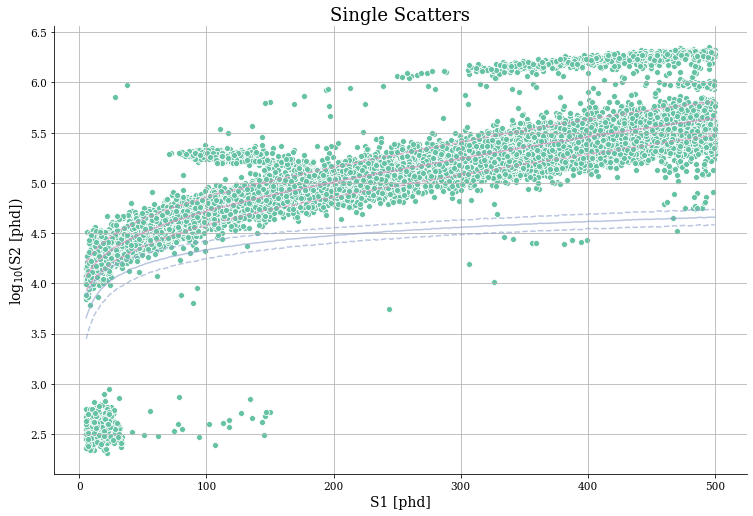

In [17]:
SingleScattersS1S2Plot = sns.relplot(x = 'S1c',
                                     y = 'logS2c',
                                     data = df_SS,
                                     height = 7, aspect = 1.5, 
                                     color = palette[0])
plotER(False, 0.6)
plotNR(False, 0.6)
plt.title("Single Scatters") 
plt.xlabel('S1 [phd]') 
plt.ylabel(r'log$_{10}$(S2 [phd])')
plt.grid(True, axis='both', which='both', color=palette[7])
# plt.xlim(0, 500)
# plt.ylim(3.25, 6)
plt.show()

In [34]:
SingleScattersHexBin = sns.jointplot(x = 'S1c',
                                     y = 'logS2c',
                                     data = df_SS,
#                                      xlim = (150, 450),
#                                      ylim = (4.25, 5.4),
                                     kind = 'hex',
                                     color = palette[0],
                                     height = 9,
                                     gridsize = (55, 50))
SingleScattersHexBin.ax_joint.plot('xER', 'yER', data = df_SS, color = palette[3], alpha = 1)
SingleScattersHexBin.ax_joint.plot('xER', 'yHiER', data = df_SS, color = palette[3], alpha = 0.6)
SingleScattersHexBin.ax_joint.plot('xER', 'yLoER', data = df_SS, color = palette[3], alpha = 0.6)
SingleScattersHexBin.ax_joint.plot('xNR', 'yNR', data = df_SS, color = palette[2], alpha = 1)
SingleScattersHexBin.ax_joint.plot('xNR', 'yHiNR', data = df_SS, color = palette[2], alpha = 0.6)
SingleScattersHexBin.ax_joint.plot('xNR', 'yLoNR', data = df_SS, color = palette[2], alpha = 0.6)
SingleScattersHexBin.ax_joint.set_xlabel('S1 [phd]')
SingleScattersHexBin.ax_joint.set_ylabel(r'log$_{10}$(S2 [phd])')
SingleScattersHexBin.ax_marg_x.set_title("Single Scatters Distribution")
plt.show()

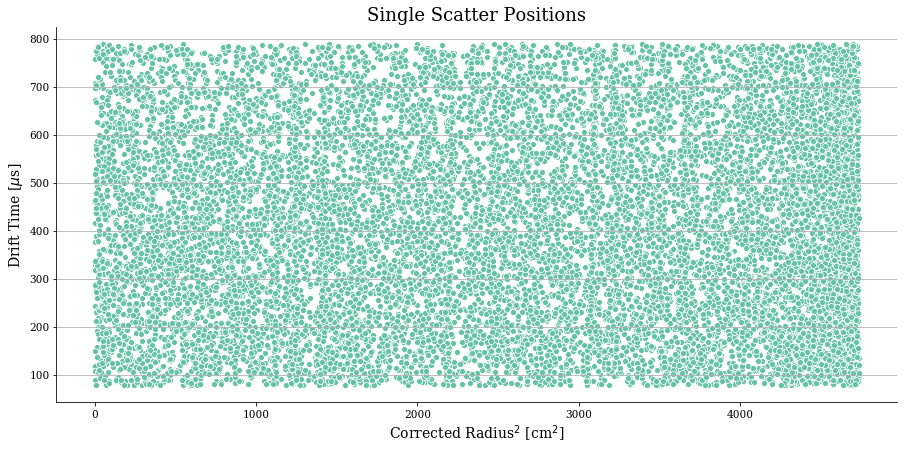

In [22]:
SingleScattersPositionPlot = sns.relplot(x = 'rc2',
                                         y = 'driftTime',
                                         data = df_SS,
                                         height = 6, aspect = 2.1, 
                                         color = palette[0])
plt.xlabel(r'Corrected Radius${}^2$ [cm${}^2$]')
plt.ylabel(r'Drift Time [$\mu$s]')
plt.title(r'Single Scatter Positions')
plt.grid(True, axis = 'y')
# plt.ylim(793, 808)
plt.show()

In [27]:
f, ax = plt.subplots(figsize=(15, 7))
plt.grid(True, alpha = 0.3)
cmap = sns.cubehelix_palette(as_cmap=True, start=2, rot=0, dark=0, light=0.95, reverse=False)
sns.kdeplot(df_SS.rc2, df_SS.driftTime, ax=ax, cmap = cmap, n_levels = 30, shade = True)
plt.xlabel(r'Corrected Radius${}^2$ [cm${}^2$]')
plt.ylabel(r'Drift Time [$\mu$s]')
plt.title(r'Single Scatter Distribution')
plt.show()

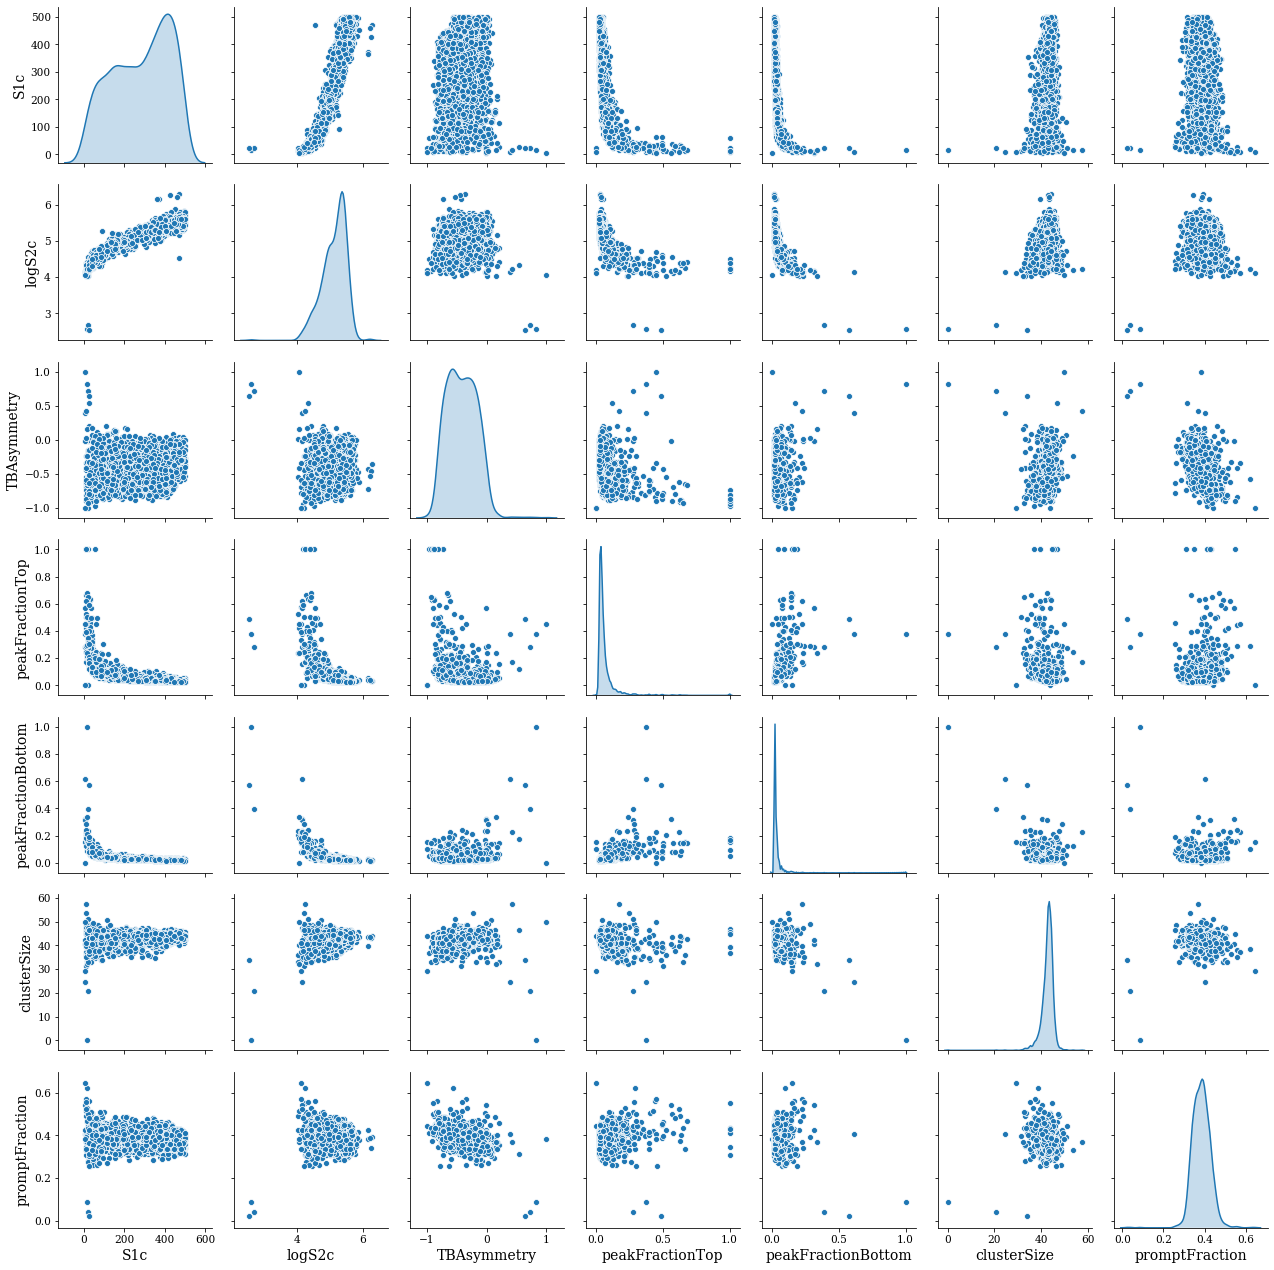

In [32]:
singleScatterPairPlot_vars = ['S1c', 
                              'logS2c', 
                              'TBAsymmetry',
                              'peakFractionTop',
                              'peakFractionBottom',
                              'clusterSize',
                              'promptFraction']

singleScatterPairPlot = sns.pairplot(df_SS.head(2000), 
                                     vars = singleScatterPairPlot_vars,
                                     palette = 'Set2',
                                     diag_kind = 'kde',
                                     aspect = 1)

In [21]:
SingleScattersCSPlot = sns.relplot(x = 'driftTime',
                                   y = 'clusterSize',  
                                   data = df_SS,
                                   height = 6, aspect = 2.1, 
                                   color = palette[0])
plt.ylabel(r'Cluster Size [cm]')
plt.xlabel(r'Drift Time [$\mu$s]')
plt.title(r'Single Scatter Cluster Size')
plt.grid(True, axis = 'y')
# plt.ylim(793, 808)
plt.show()

In [28]:
df_SS

S1c    logS2c          rc2  driftTime  eventID  \
0       99.063995  5.098454  5245.815401     581.64  3856253   
1      290.519073  5.011714  4809.596343     358.86  3856271   
2      484.050446  5.585304   653.898842     447.94  3856795   
3      229.025620  5.268730  4048.036364     369.00  3857957   
4      464.792847  5.463476  4739.309579     446.86  3858424   
...           ...       ...          ...        ...      ...   
17574  444.006500  5.446941  5187.966178      15.98  3835251   
17575  449.331085  5.580357  5184.225824      11.19  3835809   
17576  406.098938  6.246693  4906.061986     603.18  3837385   
17577  488.435303  5.385124  5299.388423       8.33  3838946   
17578  452.689301  5.659480  5027.771586     550.19  3840565   

                                            file  TBAsymmetry  \
0      b'lz_201804010000_000172_035706_raw.root'    -0.661967   
1      b'lz_201804010000_000172_035706_raw.root'    -0.332571   
2      b'lz_201804010000_000172_035707_raw.root'    -0.503264   
3      b'lz_201804010000_000172_035709_raw.root'    -0.340579   
4      b'lz_201804010000_000172_035710_raw.root'    -0.508213   
...                                          ...          ...   
17574  b'lz_201804012359_000175_007125_raw.root'    -0.017823   
17575  b'lz_201804012359_000175_007126_raw.root'     0.090392   
17576  b'lz_201804012359_000175_007129_raw.root'    -0.682872   
17577  b'lz_201804012359_000175_007132_raw.root'     0.016067   
17578  b'lz_201804012359_000175_007135_raw.root'    -0.619408   

       peakFractionTop  peakFractionBottom  clusterSize  promptFraction   xER  \
0             0.125571            0.034591    39.050921        0.438262   5.5   
1             0.047418            0.031007    40.957199        0.397704   7.5   
2             0.034230            0.015756    41.873293        0.355432   9.5   
3             0.041043            0.026177    43.114155        0.381714  11.5   
4             0.037734            0.020477    44.007360        0.357265  13.5   
...                ...                 ...          ...             ...   ...   
17574         0.077466            0.028120    43.733789        0.352367   NaN   
17575         0.053549            0.020835    44.603472        0.413592   NaN   
17576         0.046013            0.022516    42.547383        0.395609   NaN   
17577         0.055087            0.026139    45.493343        0.354730   NaN   
17578         0.042655            0.019377    43.910066        0.417822   NaN   

            yER     yHiER     yLoER   xNR       yNR     yHiNR     yLoNR  
0      4.069341  4.209606  3.929076   5.5  3.659440  3.871103  3.447777  
1      4.109857  4.247074  3.972640   7.5  3.733183  3.928180  3.538186  
2      4.146679  4.282963  4.010395   9.5  3.790563  3.970076  3.611050  
3      4.181179  4.315723  4.046635  11.5  3.842734  4.010478  3.674990  
4      4.208910  4.342675  4.075145  13.5  3.879320  4.037111  3.721529  
...         ...       ...       ...   ...       ...       ...       ...  
17574       NaN       NaN       NaN   NaN       NaN       NaN       NaN  
17575       NaN       NaN       NaN   NaN       NaN       NaN       NaN  
17576       NaN       NaN       NaN   NaN       NaN       NaN       NaN  
17577       NaN       NaN       NaN   NaN       NaN       NaN       NaN  
17578       NaN       NaN       NaN   NaN       NaN       NaN       NaN  

[17579 rows x 19 columns]

In [17]:
# Replace the filename with the location of the raw DER file for LZAP processing (in the event viewer)
df_SS['file'] = df_SS.file.astype(dtype = "str")
df_SS['file'] = '/global/projecta/projectdirs/lz/data/warehouse/MDC3/background/BACCARAT-4.11.0_DER-8.5.13/' + \
                df_SS.file.str[5:13] + '/' + df_SS.file.str[2:40]

# Remove the ER and NR band columns
df_SS = df_SS.drop(columns = ['xER', 'yER', 'yHiER', 'yLoER', 'xNR', 'yNR', 'yHiNR', 'yLoNR'])

In [18]:
df_SS.to_pickle("/global/cfs/projectdirs/lz/users/chami/AnomalousEventFinder/data/bckgData_SS.pkl")